In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('../data/processed/trials.csv')
data.drop(columns='nct_id', inplace=True)

C:\Users\olive\AppData\Local\Temp\ipykernel_17308\2384231012.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/processed/trials.csv')


In [3]:
print("missing values for categorical columns:")
data[[col for col in data.columns if data[col].dtype == np.object_]].isna().mean().sort_values(ascending=False)

missing values for categorical columns:


is_ppsd                    0.999982
is_unapproved_device       0.993142
biospec_retention          0.962940
phase                      0.579570
is_fda_regulated_device    0.529242
is_fda_regulated_drug      0.529219
primary_purpose            0.225750
has_us_facility            0.073943
model                      0.030299
agency_class               0.000000
dtype: float64

In [4]:
print("missing values for numerical columns:")
data[[col for col in data.columns if data[col].dtype in [np.float64, np.int64]]].isna().mean().sort_values(ascending=False)

missing values for numerical columns:


number_of_groups                           0.863114
number_of_secondary_outcomes_to_measure    0.278330
number_of_arms                             0.266084
num_countries                              0.062624
number_of_primary_outcomes_to_measure      0.036963
number_of_facilities                       0.000000
max_age                                    0.000000
min_age                                    0.000000
dtype: float64

In [5]:
pd.Series([data[col].dtype for col in data.columns]).unique()

array([dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')],
      dtype=object)

In [6]:
from sklearn.model_selection import train_test_split
X = data.drop(columns='terminated')
y = data['terminated']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=915, test_size=0.25, stratify=y)

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [8]:
categorical_features = [col for col in data.columns if data[col].dtype == np.object_] 
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

numerical_features = [col for col in data.columns if data[col].dtype in [np.int64, np.float64]]
numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transf', categorical_transformer, categorical_features),
        ('num_transf', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(
    steps=[
        ('preprocessing', preprocessor),
        ('log_reg', LogisticRegression(class_weight='balanced'))
    ]

)

In [9]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('log_reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat_transf', ...), ('num_transf', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the d

In [10]:
y_pred = pipeline.predict(X_test)

In [11]:
sum([False for _ in range(len(y_test))] == y_test) / len(y_test)

0.9043221539914974

In [ ]:
pipeline.score(X_test, y_test)

0.6549244213509684

In [13]:
print("Positive rate in test:", y_test.mean())
print("Predicted positive rate:", y_pred.mean())

Positive rate in test: 0.0956778460085026
Predicted positive rate: 0.3705125177137459


In [14]:
pipeline.classes_

array([False,  True])

In [15]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score
)

proba = pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC (Average Precision):", average_precision_score(y_test, proba))
print(confusion_matrix(y_test, (proba >= 0.5)))
print(classification_report(y_test, (proba >= 0.5), digits=3))

ROC-AUC: 0.7061873831622085
PR-AUC (Average Precision): 0.20636728304369395
[[50331 26247]
 [ 2974  5128]]
              precision    recall  f1-score   support

       False      0.944     0.657     0.775     76578
        True      0.163     0.633     0.260      8102

    accuracy                          0.655     84680
   macro avg      0.554     0.645     0.517     84680
weighted avg      0.870     0.655     0.726     84680



In [16]:

prec = np.array([])
rec = np.array([])
for t in np.arange(0.1, 1.0, 0.1):
    pred = (proba >= t)
    cm = confusion_matrix(y_test, pred)
    tp, fp, fn = cm[1,1], cm[0, 1], cm[1, 0]
    precision = tp / (tp + fp)
    prec = np.append(prec, precision)
    recall = tp / (tp + fn)
    rec = np.append(rec, recall)
    # print(f"threshold: {t:.1f} | precision: {precision:.4f} | recall: {recall:.4f}")
    # print(t, confusion_matrix(y_test, pred))

print("calculated pr-auc:", np.array([(rec[i-1] - rec[i])*prec[i] for i in range(1, len(prec))]).sum(), "\n\n")

calculated pr-auc: 0.23096534500169671 




In [17]:
prec

array([0.09585247, 0.10024144, 0.11488994, 0.13813695, 0.16344223,
       0.19862159, 0.25075492, 0.34925373, 0.4       ])

In [18]:
np.array([(rec[i-1] - rec[i])*prec[i] for i in range(1, len(prec))]).sum()

np.float64(0.23096534500169671)

In [19]:
pipeline.predict_proba(X_test)[:, 1] # predicted probability that each test trial was terminated

array([0.29217229, 0.41827111, 0.58571105, ..., 0.53758729, 0.30677362,
       0.34394598], shape=(84680,))

In [20]:
pos_inds = np.arange(y_pred.size)[y_pred]
pos_inds

array([    2,     3,     5, ..., 84670, 84674, 84677], shape=(31375,))

In [21]:
proba = pipeline.predict_proba(X_test)[:, 1]
proba

array([0.29217229, 0.41827111, 0.58571105, ..., 0.53758729, 0.30677362,
       0.34394598], shape=(84680,))

In [24]:
df = pd.DataFrame({"y_test":y_test, "y_proba":proba})

In [28]:
df = df.sort_values(by=['y_proba'], ascending=False)

In [51]:
def compare_head_and_tail(arr):
    for h in arr:
        print(f"top {h} are {df.head(h)['y_test'].mean()*100:.2f}% terminated")
        print(f"bottom {h} are {df.tail(h)['y_test'].mean()*100:.2f}% terminated")
        print()

compare_head_and_tail([10, 50, 100, 250, 500, 1000, 10000])

top 10 are 40.00% terminated
bottom 10 are 0.00% terminated

top 50 are 38.00% terminated
bottom 50 are 2.00% terminated

top 100 are 45.00% terminated
bottom 100 are 1.00% terminated

top 250 are 40.00% terminated
bottom 250 are 2.40% terminated

top 500 are 39.20% terminated
bottom 500 are 1.60% terminated

top 1000 are 35.20% terminated
bottom 1000 are 1.30% terminated

top 10000 are 23.56% terminated
bottom 10000 are 2.19% terminated



In [61]:
compare_head_and_tail(list(range(110, 115, 1)))

top 110 are 47.27% terminated
bottom 110 are 0.91% terminated

top 111 are 47.75% terminated
bottom 111 are 0.90% terminated

top 112 are 47.32% terminated
bottom 112 are 0.89% terminated

top 113 are 46.90% terminated
bottom 113 are 0.88% terminated

top 114 are 46.49% terminated
bottom 114 are 0.88% terminated



In [59]:
df.iloc[[111, df.shape[0]-111]]

,y_test,y_proba
162397,False,0.868487
61807,False,0.087837


In [33]:
pos_inds = np.arange(df.shape[0])[df['y_test']]
pos_inds

array([    0,     2,     3, ..., 84524, 84551, 84647], shape=(8102,))

In [66]:
y_proba_pred = proba >= .85

In [72]:
for t in np.arange(0.5, 1.0, 0.05):
    y_proba_pred = proba >= t
    print(f"threshold: {t:.2f}, accuracy: {accuracy_score(y_test, y_proba_pred):.4f}")

threshold: 0.50, accuracy: 0.6549
threshold: 0.55, accuracy: 0.7171
threshold: 0.60, accuracy: 0.7732
threshold: 0.65, accuracy: 0.8166
threshold: 0.70, accuracy: 0.8556
threshold: 0.75, accuracy: 0.8825
threshold: 0.80, accuracy: 0.8996
threshold: 0.85, accuracy: 0.9040
threshold: 0.90, accuracy: 0.9043
threshold: 0.95, accuracy: 0.9043


In [74]:
(1/1 + 2/3 + 3/5 + 4/9)/4

0.6777777777777778

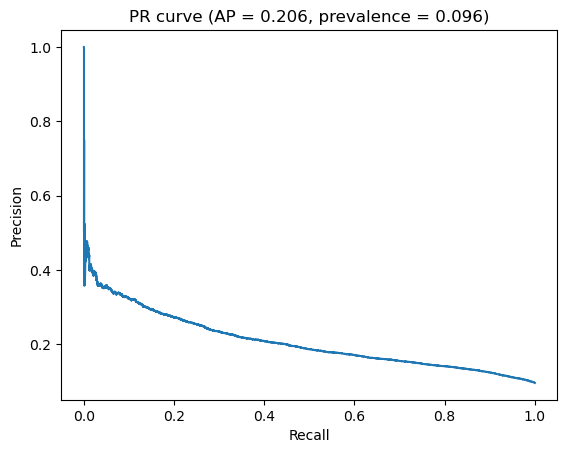

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR curve (AP = {ap:.3f}, prevalence = {y_test.mean():.3f})")
plt.show()

In [77]:
(1/3 +2/7 + 3/13)/3

0.2832722832722833